# SVM Practice Session
In this session, we will see how to use Support Vector Machines (SVM) to classify data. In a first time, we will work with generated data, and then we will use SVM to try and predict pulsars stars.

# Part 1

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Data generation

### Generating the artificial dataset

In [ ]:
# We generate 1000 points, with 2 features, and 2 classes
# Let's pick a center for each class
center1 = np.array([0, 0])
center2 = np.array([1, 1])
# We generate 500 points around each center, distributed normally
data1 = np.random.normal(loc=center1, # mean
scale=(0.5, 0.3), # std deviation
size=(500, 2))
data2 = np.random.normal(loc=center2, # mean
scale=(0.3, 0.5), # std deviation
size=(500, 2))
# We create the labels
labels1 = np.zeros(500)
labels2 = np.ones(500)
# We concatenate the data and the labels
data1 = np.concatenate((data1, labels1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data2, labels2.reshape(-1, 1)), axis=1)
# We concatenate the two classes
data = np.concatenate((data1, data2), axis=0)
# We shuffle the data
np.random.shuffle(data)

### Spliting the dataset

In [ ]:
# We split the data into train, and test sets
train, test = train_test_split(data, test_size=0.2)

### Creating the dataframes

In [ ]:
# We make a dataframe to plot the data, with columns x, y, label, set
train_df = pd.DataFrame(train, columns=['x', 'y', 'label'])
train_df['set'] = 'train'
test_df = pd.DataFrame(test, columns=['x', 'y', 'label'])
test_df['set'] = 'test'
df = pd.concat([train_df, test_df], axis=0)
del train_df, test_df

### Saving the dataset

In [ ]:
# We save the data
np.save('./generated_data.npy', data)
np.save('./generated_data_train.npy', train)
np.save('./generated_data_test.npy', test)
df.to_csv('./generated_data.csv', index=False)

### Visualize the dataset

Let's plot the data, to see what it looks like

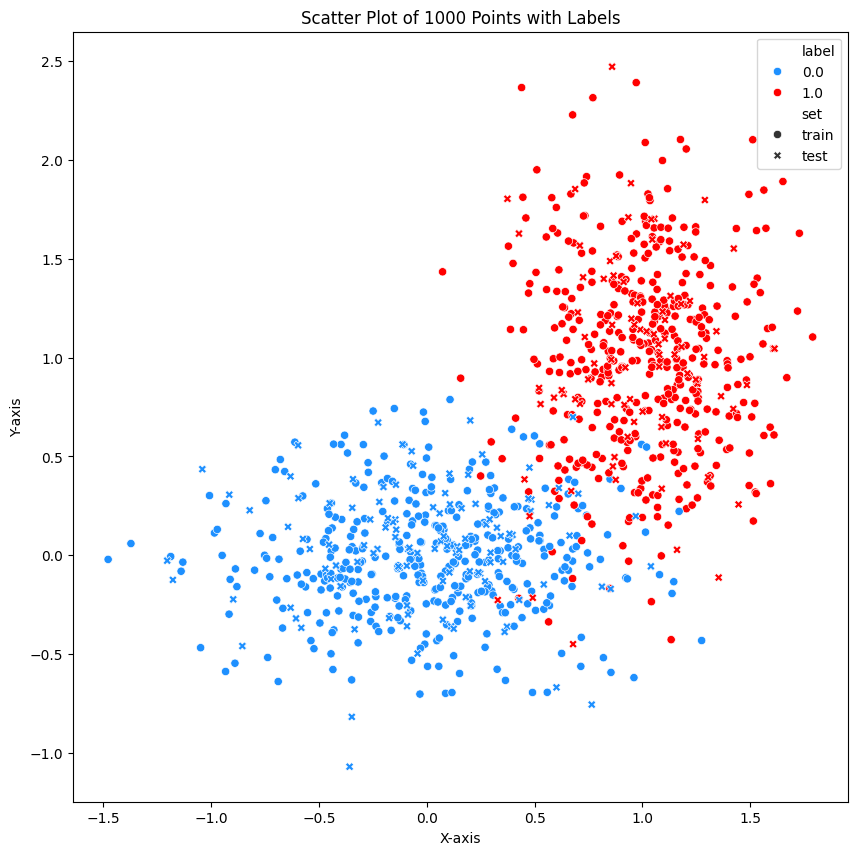

In [ ]:
# Scatter plot with different colors for each label
plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['x'], y=df['y'], hue='label',palette=['dodgerblue','red'], style='set', data=df)
# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of 1000 Points with Labels')

plt.show()

## Tuning hyperparameters

We found two ways of plotting the results. Either as a plot where each point represent a combination of hyperparameters or as a heatmap.

Best Hyperparameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


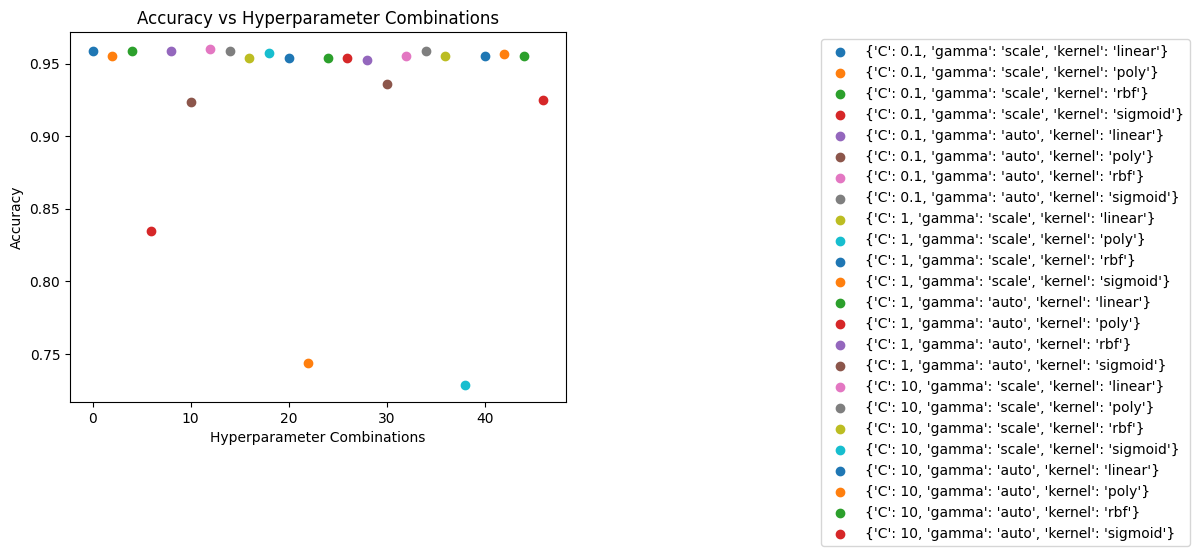

Accuracy on Test Set: 0.955


In [ ]:
# Split training data into X_train and y_train
X_train = df[df['set'] == 'train'].iloc[:, :-2]
y_train = df[df['set'] == 'train'].iloc[:, -2]

# Split test data into X_test and y_test
X_test = df[df['set'] == 'test'].iloc[:, :-2]
y_test = df[df['set'] == 'test'].iloc[:, -2]

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier
svmm = svm.SVC()

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(svmm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Plot accuracy as a function of hyperparameters
results = grid_search.cv_results_
accuracy = results['mean_test_score']
params = results['params']

fig, ax = plt.subplots()
for i, param in enumerate(params): # We consider each combination of parameters as a single value for which we need to plot the accuracy
    ax.scatter(i*2, accuracy[i], label=str(param)) # We use i*2 just to create more distance between the points for a better plot
ax.set_xlabel('Hyperparameter Combinations')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Hyperparameter Combinations')

# Move the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1.5, 1))  # Adjust the location of the lengend so it does not overlap with our graph
plt.show()


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Accuracy on Test Set:", test_accuracy)

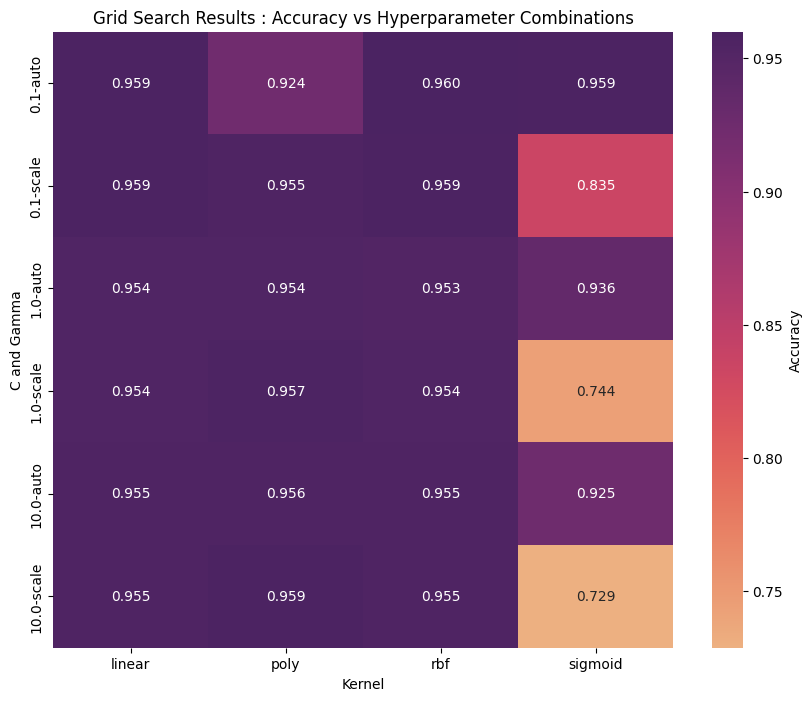

Best Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# Extract results from grid search
df_results = pd.DataFrame(results)

# Use pivot_table with multi-level index to include 'kernel' in the heatmap
heatmap_data = pd.pivot_table(df_results, values='mean_test_score', index=['param_C', 'param_gamma'], columns='param_kernel', aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='flare', fmt='.3f', cbar_kws={'label': 'Accuracy'})

plt.title('Grid Search Results : Accuracy vs Hyperparameter Combinations')
plt.xlabel('Kernel')
plt.ylabel('C and Gamma')
plt.show()

# Display the best parameters
print("Best Parameters:", best_params)


## Plotting the decision surface found and the support vectors

For better insight, we plot the decision boundary of the classifier with the hyperparameters : (C=1, kernel="linear"), (C=1, kernel="rbf"), (C=100, kernel="linear"), (C=100, kernel="rbf")

In [ ]:
# Decision surface
models = {1: {'C': 1, 'kernel': 'linear'},
          2: {'C': 1, 'kernel': 'rbf'},
          3: {'C': 100, 'kernel': 'linear'},
          4: {'C': 100, 'kernel': 'rbf'}}


for key, value in models.items():
    # Make the classifiers
    classifier = svm.SVC(C=value['C'], kernel=value['kernel'])
    # Train them
    classifier.fit(X_train, y_train)
    # Get the accuracy on the test set
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Classifier {key} - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")



Classifier 1 - Accuracy: 0.955, Precision: 0.952, Recall: 0.941, F1-score: 0.947
Classifier 2 - Accuracy: 0.955, Precision: 0.952, Recall: 0.941, F1-score: 0.947
Classifier 3 - Accuracy: 0.955, Precision: 0.952, Recall: 0.941, F1-score: 0.947
Classifier 4 - Accuracy: 0.945, Precision: 0.940, Recall: 0.929, F1-score: 0.935


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


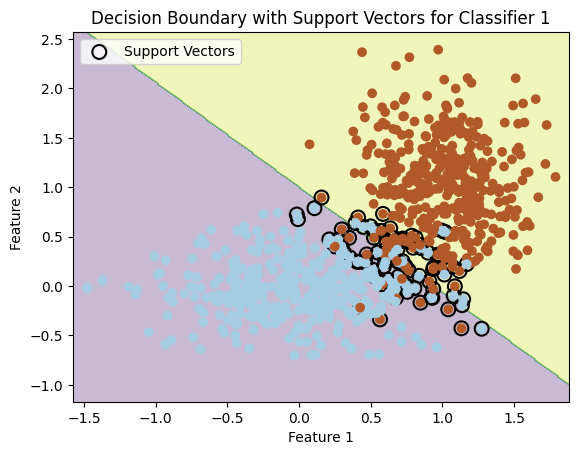

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


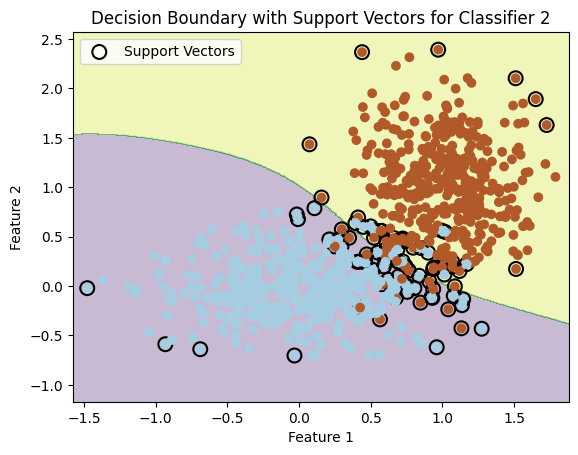

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


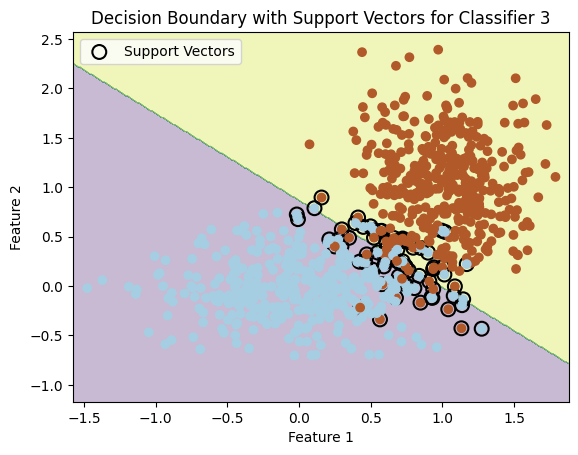

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


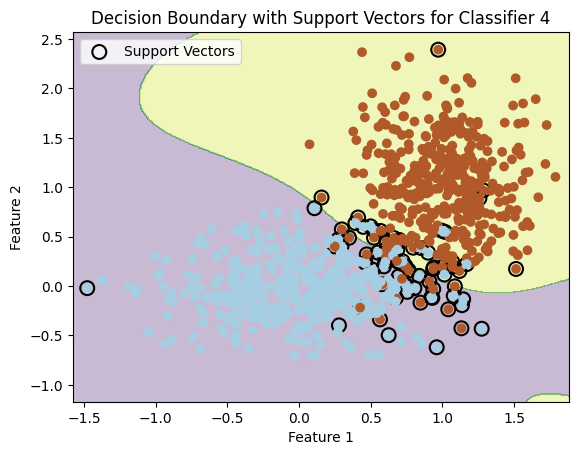

In [ ]:
# We create a grid of points
x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# We plot the decision boundary for each classifier and print the accuracy on the test set
for key, value in models.items():
    # We Create an SVM classifier with the specified hyperparameters
    svm_classifier = svm.SVC(C=value['C'], kernel=value['kernel'])

    # We train the classifier on the entire training set
    svm_classifier.fit(X_train, y_train)

    # We predict the labels for each point in the grid
    Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # We reshape the predictions to match the grid
    Z = Z.reshape(xx.shape)

    # We plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3)

    # We plot the support vectors as scatter points with empty markers (facecolors='none'), black edges (edgecolors='k'), and larger size (s=100) to distinguish them from the other data points.
    plt.scatter(svm_classifier.support_vectors_[:, 0], svm_classifier.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors') #

    # Plot the data points
    plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=plt.cm.Paired)

    # Set plot labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundary with Support Vectors for Classifier {key}')

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()

# Part 2: Pulsar dataset

## Dataset Description

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In particular, classification systems are widely adopted, which treat the candidate datasets as binary classification problems.

**Features**
*   Mean of the integrated profile.
*   Standard deviation of the integrated profile.
*   Excess kurtosis of the integrated profile.
*   Skewness of the integrated profile.
*   Mean of the DM-SNR curve.
*   Standard deviation of the DM-SNR curve.
*   Excess kurtosis of the DM-SNR curve.
*   Skewness of the DM-SNR curve.
*   Class




## Data pre-processing

In [24]:
# We read the datset
train_input_file = "pulsar_data_train.csv"
df_train = pd.read_csv(train_input_file)

test_input_file = "pulsar_data_test.csv"
df_test = pd.read_csv(test_input_file)

In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     10793 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        11350 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                   12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                5370 non-null   float64
 1    Standard deviation of the integrated profile  5370 non-null   float64
 2    Excess kurtosis of the integrated profile     4603 non-null   float64
 3    Skewness of the integrated profile            5370 non-null   float64
 4    Mean of the DM-SNR curve                      5370 non-null   float64
 5    Standard deviation of the DM-SNR curve        4846 non-null   float64
 6    Excess kurtosis of the DM-SNR curve           5370 non-null   float64
 7    Skewness of the DM-SNR curve                  5126 non-null   float64
 8   target_class                                   0 non-null      float64
dtypes: float64(9)
memory usage: 377.7 KB


In [27]:
df_train.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,12528.000000,12528.000000,10793.000000,12528.000000,12528.000000,11350.000000,12528.000000,11903.000000,12528.000000
mean,111.041841,46.521437,0.478548,1.778431,12.674758,26.351318,8.333489,105.525779,0.092034
std,25.672828,6.801077,1.064708,6.208450,29.613230,19.610842,4.535783,107.399585,0.289085
min,5.812500,24.772042,-1.738021,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.871094,42.362222,0.024652,-0.188142,1.910535,14.404353,5.803063,35.199899,0.000000
50%,115.183594,46.931022,0.223678,0.203317,2.792642,18.412402,8.451097,83.126301,0.000000
75%,127.109375,50.979103,0.473125,0.932374,5.413253,28.337418,10.727927,139.997850,0.000000
max,189.734375,91.808628,8.069522,68.101622,222.421405,110.642211,34.539844,1191.000837,1.000000


### Data cleaning

#### Removing duplicates

In [28]:
# Find duplicates based on all columns
duplicate_rows = df_train[df_train.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows))

# Remove duplicates
df_train_no_duplicates = df_train.drop_duplicates()

# Check the shape of the DataFrame before and after removing duplicates
print("Shape before removing duplicates:", df_train.shape)
print("Shape after removing duplicates:", df_train_no_duplicates.shape)

Number of duplicate rows: 0
Shape before removing duplicates: (12528, 9)
Shape after removing duplicates: (12528, 9)


Apparently, there are no duplicates.

#### Handling missing values

In [29]:
print(df_train.isnull().sum())

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64


In [30]:
print(df_test.isnull().sum())

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile        767
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve           524
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     244
target_class                                     5370
dtype: int64


Using SimpleImputer with strategy='mean'

In [31]:
X_train = df_train.iloc[:, :-1].values
X_test = df_test.iloc[:, :-1].values

# Initialize the SimpleImputer with strategy='mean' for mean imputation
mean_imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data
mean_imputer.fit(X_train)

# Transform the data by filling missing values with the mean of each column
df_X_train_cleaned_meanimputer = pd.DataFrame(mean_imputer.transform(X_train), columns = df_train.iloc[:, :-1].columns)
df_X_test_cleaned_meanimputer = pd.DataFrame(mean_imputer.transform(X_test), columns = df_test.iloc[:, :-1].columns)

In [35]:
# We split the training set into a training part and a validation part
X_train_mean, X_valid_mean, y_train_mean, y_valid_mean = train_test_split(df_X_train_cleaned_meanimputer, df_train['target_class'], test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train_mean, y_train_mean)

y_pred_mean = svm.predict(X_valid_mean)
accuracy = accuracy_score(y_valid_mean, y_pred_mean)
print("Accuracy for SimpleImputer model using the mean :", accuracy)

Accuracy for SimpleImputer model using the mean : 0.9712689545091779


SimpleImputer with strategy='median'

In [36]:
# Initialize the SimpleImputer with strategy='median' for median imputation
median_imputer = SimpleImputer(strategy='median')

# Fit the imputer to the data
median_imputer.fit(X_train)

# Transform the data by filling missing values with the mean of each column
df_X_train_cleaned_medianimputer = pd.DataFrame(median_imputer.transform(X_train), columns = df_train.iloc[:, :-1].columns)
df_X_test_cleaned_medianimputer = pd.DataFrame(median_imputer.transform(X_test), columns = df_test.iloc[:, :-1].columns)

In [37]:
X_train_median, X_valid_median, y_train_median, y_valid_median = train_test_split(df_X_train_cleaned_medianimputer, df_train['target_class'], test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train_median, y_train_median)

y_pred_median = svm.predict(X_valid_median)
accuracy = accuracy_score(y_valid_median, y_pred_median)
print("Accuracy for SimpleImputer model using the median :", accuracy)

Accuracy for SimpleImputer model using the median : 0.9716679968076616


Using k-Nearest Neighbor

In [38]:
# Exploirng the kNN
# Impute missing values based on the values of nearest neighbors.

df_X_train = df_train.iloc[:, :-1].copy() #removing the target column
df_X_test = df_test.iloc[:, :-1].copy()

knn_imputer = KNNImputer(n_neighbors=2)

df_X_train_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_X_train), columns=df_X_train.columns)
df_X_test_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_X_test), columns=df_X_test.columns)


In [39]:
X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = train_test_split(df_X_train_knn_imputed, df_train['target_class'], test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train_knn, y_train_knn)

y_pred_knn = svm.predict(X_valid_knn)
accuracy = accuracy_score(y_valid_knn, y_pred_knn)
print("Accuracy for using KNN model to fill missing values:", accuracy)

Accuracy for using KNN model to fill missing values: 0.9752593774940144


Comparing SVM performance for each method, using k-NN to fill missing values resulted in a slightly better accuracy.

For the remaining part, we will use the resulted dataframes from applying kNN.

### Converting categorical variables to numerical format

In [40]:
df_X_train_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 8 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                12528 non-null  float64
 1    Standard deviation of the integrated profile  12528 non-null  float64
 2    Excess kurtosis of the integrated profile     12528 non-null  float64
 3    Skewness of the integrated profile            12528 non-null  float64
 4    Mean of the DM-SNR curve                      12528 non-null  float64
 5    Standard deviation of the DM-SNR curve        12528 non-null  float64
 6    Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7    Skewness of the DM-SNR curve                  12528 non-null  float64
dtypes: float64(8)
memory usage: 783.1 KB


In [41]:
df_X_test_knn_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5370 entries, 0 to 5369
Data columns (total 8 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0    Mean of the integrated profile                5370 non-null   float64
 1    Standard deviation of the integrated profile  5370 non-null   float64
 2    Excess kurtosis of the integrated profile     5370 non-null   float64
 3    Skewness of the integrated profile            5370 non-null   float64
 4    Mean of the DM-SNR curve                      5370 non-null   float64
 5    Standard deviation of the DM-SNR curve        5370 non-null   float64
 6    Excess kurtosis of the DM-SNR curve           5370 non-null   float64
 7    Skewness of the DM-SNR curve                  5370 non-null   float64
dtypes: float64(8)
memory usage: 335.8 KB


As the type of all columns is float64, there are no categorical columns to convert.

### Normalize numerical features

In [42]:
X_train_cleaned = df_X_train_knn_imputed.iloc[:, :].values
X_test_cleaned = df_X_test_knn_imputed.iloc[:, :].values

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_normalized = scaler.fit_transform(X_train_cleaned)

# Transform the test data using the same scaler
X_test_normalized = scaler.transform(X_test_cleaned)

In [43]:
pd.DataFrame(X_train_normalized, columns=df_X_train.columns).describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000,12528.000000
mean,0.572142,0.324441,0.226129,0.051082,0.056081,0.183362,0.304486,0.090260
std,0.139586,0.101453,0.108579,0.088827,0.133268,0.189149,0.120379,0.089845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.516842,0.262397,0.180064,0.022946,0.007638,0.068269,0.237329,0.031427
50%,0.594661,0.330551,0.200054,0.028546,0.011608,0.107111,0.307607,0.071578
75%,0.659502,0.390937,0.225186,0.038977,0.023402,0.202343,0.368034,0.119195
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
pd.DataFrame(X_test_normalized, columns=df_X_test.columns).describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,0.572832,0.325837,0.225513,0.050693,0.055175,0.184529,0.301838,0.087613
std,0.139236,0.103535,0.107776,0.086887,0.131161,0.187000,0.117723,0.087060
min,0.001996,0.000292,-0.014070,0.000389,0.000000,0.000000,0.011078,0.000010
25%,0.517766,0.263080,0.180079,0.022925,0.007845,0.069987,0.234606,0.030196
50%,0.592346,0.332046,0.199920,0.028305,0.011779,0.108477,0.305818,0.070066
75%,0.659035,0.393239,0.225005,0.038783,0.024198,0.206115,0.365495,0.115709
max,1.015674,1.103977,0.952980,0.961146,1.004369,0.990999,1.000000,1.000000


## Scaling

In [45]:
# Apply Standard scaling to ensure feature uniformity
# Create the StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_normalized)

# Apply the same scaler to the test data
X_test_scaled = scaler.transform(X_test_normalized)

In [46]:
pd.DataFrame(X_train_scaled, columns=df_X_train.columns).describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,1.252800e+04,1.252800e+04,1.252800e+04,1.252800e+04,1.252800e+04,1.252800e+04,1.252800e+04,1.252800e+04
mean,1.018059e-16,-5.090295e-17,-2.563580e-16,1.417909e-17,2.949251e-17,-1.999252e-16,-7.373129e-17,4.537310e-18
std,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00,1.000040e+00
min,-4.099024e+00,-3.198061e+00,-2.082710e+00,-5.750967e-01,-4.208269e-01,-9.694413e-01,-2.529489e+00,-1.004659e+00
25%,-3.961836e-01,-6.115768e-01,-4.242701e-01,-3.167701e-01,-3.635082e-01,-6.085014e-01,-5.579029e-01,-6.548532e-01
50%,1.613347e-01,6.022593e-02,-2.401607e-01,-2.537150e-01,-3.337194e-01,-4.031425e-01,2.592993e-02,-2.079451e-01
75%,6.258826e-01,6.554613e-01,-8.689068e-03,-1.362806e-01,-2.452213e-01,1.003555e-01,5.279206e-01,3.220597e-01
max,3.065329e+00,6.659092e+00,7.127554e+00,1.068315e+01,7.083152e+00,4.317596e+00,5.777922e+00,1.012605e+01


In [47]:
pd.DataFrame(X_test_scaled, columns=df_X_test.columns).describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,0.004950,0.013769,-0.005671,-0.004377,-0.006794,0.006172,-0.021996,-0.029470
std,0.997539,1.020561,0.992650,0.978193,0.984232,0.988677,0.977970,0.969039
min,-4.084721,-3.195184,-2.212296,-0.570721,-0.420827,-0.969441,-2.437459,-1.004547
25%,-0.389565,-0.604843,-0.424138,-0.316998,-0.361955,-0.599417,-0.580524,-0.668561
50%,0.144749,0.074971,-0.241398,-0.256429,-0.332435,-0.395918,0.011069,-0.224774
75%,0.622535,0.678156,-0.010356,-0.138466,-0.239242,0.120296,0.506829,0.283260
max,3.177624,7.684012,6.694486,10.245726,7.115934,4.270006,5.777922,10.126045


## Hyperparameters tuning

### Grid Search Cross Validation

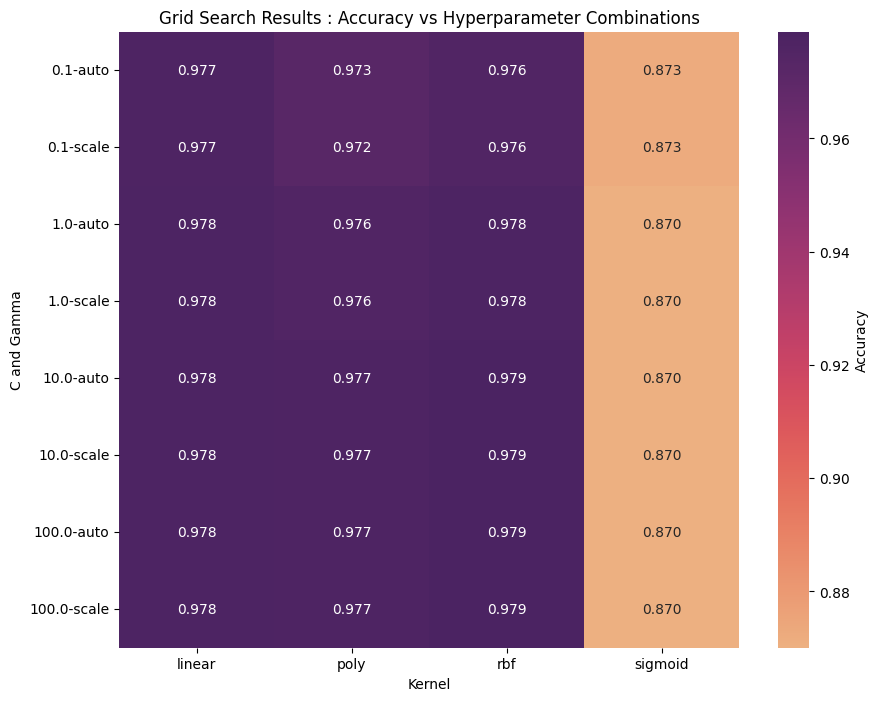

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [49]:
# Perform grid search using cross-validation to find optimal hyperparameters.

# Define a parameter grid for hyperparameter tuning.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Make a classifier
svm_clf = SVC()

# Perform grid search using cross-validation to find optimal hyperparameters
y_train = df_train.iloc[:,-1]
grid_search = GridSearchCV(svm_clf, param_grid)
grid_search.fit(X_train_scaled, y_train)

# Extract results from grid search
results = pd.DataFrame(grid_search.cv_results_)

# Use pivot_table with multi-level index to include 'kernel' in the heatmap
heatmap_data = pd.pivot_table(results, values='mean_test_score', index=['param_C', 'param_gamma'], columns='param_kernel', aggfunc=np.mean)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='flare', fmt='.3f', cbar_kws={'label': 'Accuracy'})

plt.title('Grid Search Results : Accuracy vs Hyperparameter Combinations')
plt.xlabel('Kernel')
plt.ylabel('C and Gamma')
plt.show()

# Display the best parameters
print("Best Parameters:", grid_search.best_params_)


In [51]:
# Run svm classifier with the best parameters on the test set to create the final results
# Make the classifiers
classifier = SVC(C=10, gamma='scale', kernel='rbf')
# Train them
classifier.fit(X_train_scaled, y_train)
# Get the accuracy on the test set
y_pred = classifier.predict(X_test_scaled)

In [52]:
# Convert y_pred to a DataFrame
df_pred = pd.DataFrame(y_pred, columns=['target_class'])
# Save the DataFrame to a CSV file
df_pred.to_csv('y_pred_test.csv', index=False)